In [1]:
import random
from random import randrange

from ase.io import write
from ase.data import atomic_numbers
from ase.ga.data import PrepareDB
from ase.visualize import view
from ase.calculators.siesta import Siesta
from ase.units import Ry
from ase import Atoms

import numpy as np
import os

from pyxtal import pyxtal

import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Inputs

In [2]:
name = 'C2'                                  
# Chemical species of the structure      
species = ['C']
# Quantity of chemical species in elemental cell                                  
quantity = [2]     
# Number of atoms in cell                              
n_atoms = sum(quantity)    
# Thickness of the structure                      
thickness = 5.0                                 

# Number of structures in population
pop_size = 10
# Number of generations
number_generations = 5   
# Percentage of best indyviduals passing to the next generation                                   
prob= 0.5           
# Number of indyviduals passing to next generation
num_selected = int(prob*pop_size)                                   

## Siesta calculator 
Siesta User's Guide: <https://departments.icmab.es/leem/SIESTA_MATERIAL/Docs/Manuals/siesta-4.1-b4.pdf> 

In [3]:
calc = Siesta(label=name,       
               xc='PBE',
               mesh_cutoff=200 * Ry,
               energy_shift=0.01 * Ry,
               basis_set='SZP',
               kpts=[12, 12, 1],
               pseudo_path='/home/czeski/Pobrane/siesta-4.1-b4/pseudo',
               fdf_arguments={'MaxSCFIterations': 500,   
                              'DM.Tolerance': 1.E-5,
                              'DM.NumberPulay': 6,                        
                              'DM.NumberBroyden': 0,
                              'DM.MixingWeight': 0.1000000000,             
                              'DM.OccupancyTolerance':0.1000000000E-11,         
                              'DM.NumberKick': 0,                        
                              'DM.KickMixingWeight': 0.5000000000,
                              'MD.NumCGsteps': 150,                        
                              'MD.TypeOfRun': 'CG',                       
                              'MD.VariableCell': 'F',                        
                              'WriteMullikenPop': 1,    
                              'WriteDenchar': True,      
                              'WriteKpoints': True,      
                              'WriteForces': True,      
                              'WriteDM': True,      
                              'WriteXML': True,      
                              'WriteEigenvalues': False, 
                              'WriteCoorStep': True,      
                              'WriteMDhistory': True,    
                              'WriteMDXmol': True,      
                              'WriteCoorXmol': True, 
                             },)

In [4]:
Vector = np.ndarray

def dist(v1: Vector, v2: Vector) -> float: 
    """Returns distance two atoms

    Args:
        v1 (numpy.ndarray): First vector 
        v2 (numpy.ndarray): Second vector

    Returns:
        float: Distance of two vectors
    """
    
    d = np.sqrt((v1[0] - v2[0]) * (v1[0] - v2[0]) + (v1[1] - v2[1]) * (v1[1] - v2[1]) + (v1[2] - v2[2]) * (v1[2] - v2[2]))
    return d

In [5]:
def check_dist(number_atoms: int, positions: Vector, d_min: float, d_max: float) -> bool:
    """Restrict of the distance between atoms 

    Args:
        number_atoms (int): Number of atoms
        positions (list[float]): Atom positions   
        d_min (float): Minimum allowable distance
        d_max (float): Maximum allowable distance

    Returns:
        bool: Returns True if conditions are fulfilled anyway False
    """

    flag = True
    for i in range(number_atoms):
        for j in range(number_atoms):
            if i != j:
                distance = dist(positions[i], positions[j])
                if (distance < d_min) or (distance > d_max):
                    flag = False
    return flag

## Initialization of a random structure

In [6]:
def init_struct() -> Atoms:  
    """Initialization of the random structure

    Returns:
        ase.atoms.Atoms: Structure
    """

    atoms_out = None

    number_attempts = 2000 # no of attempts
    d_min = 1.0 # min distance
    d_max = 3.5 # max distance
    
    for i in range(number_attempts):
        group_id = randrange(230) + 1 
        my_crystal = pyxtal()
        
        try:
            my_crystal.from_random(2, group_id, species, quantity, thickness=thickness)
        except:
            continue
        
        atoms = my_crystal.to_ase()
        positions = atoms.get_positions()
        number_atoms = len(atoms.get_chemical_symbols()) 
        


        flag = check_dist(number_atoms, positions, d_min, d_max)
        
        if flag==True:
            atoms_out = atoms
            break
    return atoms_out

# Indyvidual

In [7]:
class Indyvidual:
    def __init__(self, structure: Atoms,n_gen: int) -> None:
        """ Indyvidual constructor

        Args:
            structure (ase.atoms.Atoms) : Atom 
            n_gen (int) : Number of the generation
        """
        
        self.calc = calc                    
        self.init_structure = structure     
        self.energy = 0.0
        self.ngen = n_gen
        self.status = 'Random'
        
        
    def calc_energy(self) -> None:
        """Calculates the energy of the indyvidual
        """
        try:
            self.init_structure.calc = calc
            self.energy = self.init_structure.get_potential_energy()
        except:
            print("energy calculation failed")
            self.energy = +1000.
            
            
    def next_gen(self) -> None:
        """Updates the generaton number
        """
        self.ngen = self.ngen + 1
        
        
    def mutation(self) -> None:
        positions = self.init_structure.get_positions()
        new = [ n + (random.random()-0.5) for n in positions]    
        self.init_structure.set_positions(new)
        self.status = 'Mutated'
        
    
    def get_init_structure(self) -> Atoms:
        """Returns the structure of the indyvidual
        
        Returns:
            ase.atoms.Atoms: Structure of the indyvidual
        """
        return self.init_structure.copy()
    
    
    def get_energy(self) -> float:
        """Returns the energy of the indyvidual
        
        Returns:
            float: Energy of the structure
        """
        return self.energy
    
    
    def get_ngen(self) -> int:
        """Returns the generation number from which the individual came
        
        Returns:
            int: Generation number
        """
        return self.ngen

    
    def get_position(self) -> Vector:
        """Returns Atoms positions.

        Returns:
            numpy.ndarray: Vector of Atoms positions
        """
        return self.init_structure.get_positions()
    

    def get_status(self) -> str:
        """Returns where the individual came from

        Returns:
            str: Origin of the individual
        """
        return self.status

    
    def set_status(self, status) -> None:
        """Sets new indyvidual status
        """
        self.status = status

    

    

In [8]:
class Population:
    def __init__(self) -> None:
        self.population_size = pop_size
        self.indyviduals = []
        self.n_selected = num_selected

        
    def add_indyvidual(self, indyvidual: Atoms) -> None:
        """Adds a new individual to the population provided it is not full
        
        Args:
            indyvidual (ase.atoms.Atoms): Structure
        """
        if len(self.indyviduals) < self.population_size:
            self.indyviduals.append(indyvidual)

            
    def fill_up(self, n_gen: int) -> None:
        """ Fills the population with new individuals until it is full

        Returns:
            Sorted population of indyviduals
        """

        while len(self.indyviduals) < self.population_size:
            self.indyviduals.append(Indyvidual(init_struct(),n_gen))

            
    def purge(self) -> None:
        """ Removes the worst individuals.
        """
        self.indyviduals = self.indyviduals[:self.n_selected]

        
    def energy_calculator(self) -> None:
        """Calculates the energies of each individual in the population, then sorts them and displays.

        """

        for indyvidual in self.indyviduals:
                indyvidual.calc_energy()        
        self.indyviduals = sorted(self.indyviduals, key=lambda x: x.energy) 

        # Printing sorted energy
        for indyvidual in self.indyviduals:
            print(indyvidual.get_energy())

            
    def choice_by_rulette(self) -> Atoms:
        """ Choice the Indyvidual using Choice by the rulette.

        Returns:
            Chosen indyvidual
        """

        indyviduals = self.indyviduals

        indyviduals = indyviduals[1:] # Delete the best indyvidual becouse it's untouchable

        #Totaly population fitness
        population_sum = sum([individual.get_energy() for individual in indyviduals])


        
        #Each individual probability
        individuals_prob = [individual.get_energy()/population_sum for individual in indyviduals]
        
        n = np.arange(0,len(indyviduals))
        chosen_num =  np.random.choice(n, p=individuals_prob)

        return indyviduals[chosen_num]    

    
    def crossover(self) -> None:
        """ Takes two random structures and swaps their random atom positions 
        """
    
        while True:

            # Draw 2 indyviduals
            rand_ind1 = random.randint(0,pop_size-1)
            rand_ind2 = random.randint(0,pop_size-1)

            if rand_ind1 == rand_ind2:
                continue
            # Draw atom to swap
            rand_atom1 = random.randint(0,n_atoms-1)
            rand_atom2 = random.randint(0,n_atoms-1)

            
            # Swap atoms positions
            temp = self.indyviduals[rand_ind1].get_init_structure()[rand_atom1].position
            self.indyviduals[rand_ind1].get_init_structure()[rand_atom1].position = self.indyviduals[rand_ind2].get_init_structure()[rand_atom2].position
            self.indyviduals[rand_ind2].get_init_structure()[rand_atom2].position = temp

            # Set status of indyvidual as Crossovered
            self.indyviduals[rand_ind1].set_status("Crossovered")
            self.indyviduals[rand_ind2].set_status("Crossovered")
            break

        


## Starting population

In [9]:
pop = Population()
best = []
data=[]

#Starting population
print(f"Energy of structures {name} in the starting population:")
pop.fill_up(0)
pop.energy_calculator()
data.append(pop.indyviduals)

for g in range(number_generations):
    print(f"\nEnergy of the structures {name} in the generation nr {g+1}/{number_generations}:")
    pop.purge()
    pop.fill_up(g+1)
    pop.choice_by_rulette().mutation()
    pop.choice_by_rulette().mutation()
    pop.crossover()
    pop.energy_calculator()

    # Colecting data
    best.append(pop.indyviduals[0].get_energy())
    data.append(pop.indyviduals)
    




Energy of structures C2 in the starting population:
-305.200962
-303.051565
-300.846953
-300.7274
-300.671919
-300.244033
-299.815389
-297.337054
-292.459533
-276.844457

Energy of the structures C2 in the generation nr 1/5:
-308.136218
-307.856244
-305.200962
-303.424247
-303.051565
-300.846953
-300.7274
-300.673
-300.651868
-299.757479

Energy of the structures C2 in the generation nr 2/5:
-308.136218
-307.855033
-305.200962
-303.051565
-302.758847
-301.8415
-300.532006
-293.963494
-288.34101
-275.56028

Energy of the structures C2 in the generation nr 3/5:
-308.188476
-308.136218
-307.855033
-303.425359
-303.056301
-303.051565
-300.744933
-300.460835
-300.458121
-289.530085

Energy of the structures C2 in the generation nr 4/5:
-308.188476
-308.136263
-307.855292
-304.123209
-303.425359
-303.056301
-302.732413
-300.757019
-265.514799
-250.403358

Energy of the structures C2 in the generation nr 5/5:
-308.188476
-308.136263
-307.854716
-305.005249
-304.848299
-304.123209
-303.425393


## Creating Database 

In [10]:
ind = []
for i in range(len(data)):
    for j in range(pop_size):
        ind.append(data[i][j])    

In [11]:
d = {'indyvidual': ind}
df=pd.DataFrame(data = d)
df

def get_energyDF(x):
    return x.get_energy()

def get_ngenDF(x):
    return x.get_ngen()

def get_statusDF(x):
    return x.get_status()


df['Energy'] = df['indyvidual'].apply(get_energyDF)
df['Generation_Number'] = df['indyvidual'].apply(get_ngenDF)
df['Status'] = df['indyvidual'].apply(get_statusDF)

df = df.drop_duplicates(subset=['indyvidual'], keep='last')
df.sort_values('Energy')


,indyvidual,Energy,Generation_Number,Status
50,<__main__.Indyvidual object at 0x7ff31d6768b0>,-308.188476,3,Random
51,<__main__.Indyvidual object at 0x7ff31d676460>,-308.136263,1,Mutated
52,<__main__.Indyvidual object at 0x7ff3727cda30>,-307.854716,1,Crossovered
53,<__main__.Indyvidual object at 0x7ff31d673400>,-305.005249,5,Random
54,<__main__.Indyvidual object at 0x7ff31d5d74c0>,-304.848299,5,Random
55,<__main__.Indyvidual object at 0x7ff31d5d7610>,-304.123209,4,Crossovered
56,<__main__.Indyvidual object at 0x7ff31d673760>,-303.425393,1,Mutated
45,<__main__.Indyvidual object at 0x7ff31d60ee80>,-303.056301,0,Crossovered
35,<__main__.Indyvidual object at 0x7ff3727cda00>,-303.051565,0,Random
46,<__main__.Indyvidual object at 0x7ff370e1bca0>,-302.732413,4,Random


#### Writting best structure espresso_in file,  writting DataBase to csv

In [14]:
write(filename=f"./Structures/OstatecznaStruktura_{name}.in", images=pop.indyviduals[0].init_structure, format='espresso-in')
df = df[['Energy', 'Generation_Number','Status']]
df.to_csv(f"./Databases/DataBase_{name}.csv")

#### Creating best Indyviduals Plot

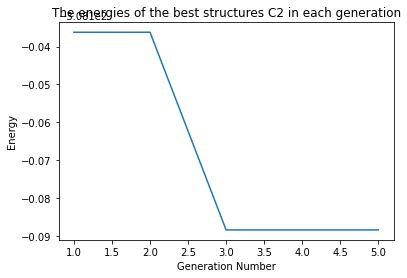

In [15]:
f = sns.lineplot(x=np.arange(1, number_generations+1), y=best)
f.set(xlabel='Generation Number', ylabel='Energy', title=f'The energies of the best structures {name} in each generation')
sns.axes_style()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})